# Model Comparison and Hierarchical Modeling

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pyjags
import scipy.special as sspecial

import dist_utils
import plot_utils

In [2]:
%load_ext autoreload

%autoreload 2

# Exercise 1

Compare models with vague vs. specific priors analytically.

In [3]:
def prob_data_given_model(z, N, beta_params):
    """
    The probability of `z` heads in `N` flips for a coin with
    bias that equals `beta(a, b)`.
    """
    a, b = beta_params.a, beta_params.b
    return np.exp(sspecial.betaln(z + a, N - z + b) - sspecial.betaln(a, b))

In [4]:
def models_posterior_probabilities(z, N, m1_params, m2_params):
    """
    Calculate the posterior probabilities of two competing models,
    each describe the bias of a coin as beta distributed with
    different parameters. Assumes no prior bias
    (`p(model_1) = p(model_2) = 0.5`).
    """
    prob_data_m1 = prob_data_given_model(z, N, m1_params)
    prob_data_m2 = prob_data_given_model(z, N, m2_params)
    bf = prob_data_m1 / prob_data_m2
    prob_m1 = bf / (1 + bf)
    prob_m2 = 1 - prob_m1
    return prob_m1, prob_m2

In [5]:
z, N = 7, 10

## Question A

In [6]:
model_1_beta_params = dist_utils.beta_params_from_w_and_k(0.25, 6)
model_2_beta_params = dist_utils.beta_params_from_w_and_k(0.75, 6)
models_posterior_probabilities(z, N, model_1_beta_params, model_2_beta_params)

(0.2500000000000001, 0.7499999999999999)

## Question B

In [7]:
model_1_beta_params = dist_utils.beta_params_from_w_and_k(0.25, 202)
model_2_beta_params = dist_utils.beta_params_from_w_and_k(0.75, 202)
models_posterior_probabilities(z, N, model_1_beta_params, model_2_beta_params)

(0.015957198625130557, 0.9840428013748694)

## Question C

Question: "Why are the posterior probabilities so different in parts A and B, even though the modes of the factories are the same?"

Because in part A the models are vague, so the data can fit both to a degree. In part B the models are very specific so the data cannot fit one of the models almost at all.

# Exercise 2

Explore hierarchical models: one coin from one factory out of two factories.

In [8]:
CHAINS = 4
ITERATIONS = 2500

In [9]:
def run_model(code, data, init=None):
    model = pyjags.Model(code=code, data=data, init=init, chains=CHAINS)
    return model.sample(vars=['m', 'theta'], iterations=ITERATIONS)


def plot_hierarchy(trace):
    fig = plt.figure()
    grid = plt.GridSpec(2, 5)
    
    ax = plt.subplot(grid[:, 0])
    plot_utils.dist(trace['m'][0], ax=ax)
    ax.set(xlabel='m', title='model index')
    
    ax = plt.subplot(grid[:, 1:3])
    plot_utils.dist(trace['theta'][0], ax=ax)
    ax.set(xlim=(0, 1), xlabel=r'$\theta$', title=r'marginal $p(\theta | D)$')
    
    for m in np.unique(trace['m'][0]):
        ax = plt.subplot(grid[int(m) - 1, 3:])  # back to 0 based indexing
        plot_utils.dist(trace['theta'][0][trace['m'][0] == m], ax=ax)
        ax.set(xlim=(0, 1), xlabel=r'$\theta$', title=fr'$\theta$ when m={int(m)}')

    fig.tight_layout()

In [10]:
code = """
model {
    z ~ dbin(theta, N)
    theta ~ dbeta(omega[m] * (kappa - 2) + 1, (1 - omega[m]) * (kappa - 2) + 1)
    omega[1] = 0.25
    omega[2] = 0.75
    m ~ dcat(mPriorProb[])
    mPriorProb[1] = 0.5
    mPriorProb[2] = 0.5
}
"""

## Question A + B

Sampling the prior

sampling: iterations 10000 of 10000, elapsed 0:00:00, remaining 0:00:00


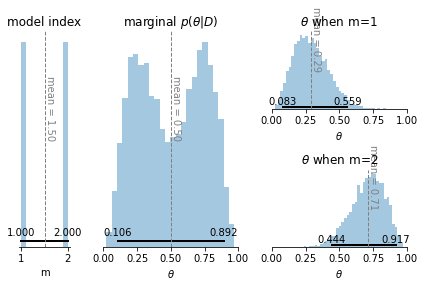

In [11]:
data = {'N': 9, 'kappa': 12}
trace = run_model(code, data)
plot_hierarchy(trace)

Sampling the posterior

adapting: iterations 4000 of 4000, elapsed 0:00:00, remaining 0:00:00
sampling: iterations 10000 of 10000, elapsed 0:00:00, remaining 0:00:00


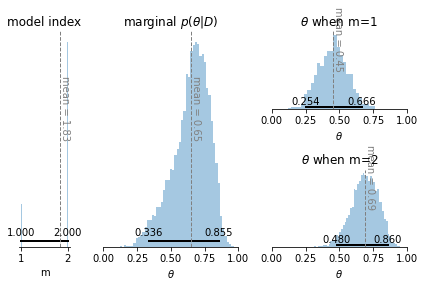

In [12]:
data = {'N': 9, 'z': 6, 'kappa': 12}
trace = run_model(code, data)
plot_hierarchy(trace)

## Question C

Repeating the same analysis but with the data in the the analytical analysis from Exercise 1.

In [13]:
def models_probability(trace):
    m = trace['m'][0].reshape(-1)
    return np.mean([m == x for x in np.unique(m)], axis=1)

adapting: iterations 4000 of 4000, elapsed 0:00:00, remaining 0:00:00
sampling: iterations 10000 of 10000, elapsed 0:00:00, remaining 0:00:00


array([0.2416, 0.7584])

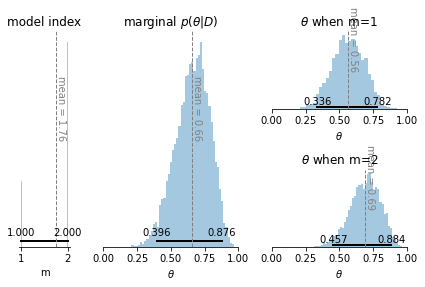

In [14]:
data = {'z': 7, 'N': 10, 'kappa': 6}
trace = run_model(code, data)
plot_hierarchy(trace)
models_probability(trace)

adapting: iterations 4000 of 4000, elapsed 0:00:00, remaining 0:00:00
sampling: iterations 10000 of 10000, elapsed 0:00:00, remaining 0:00:00


array([1.])

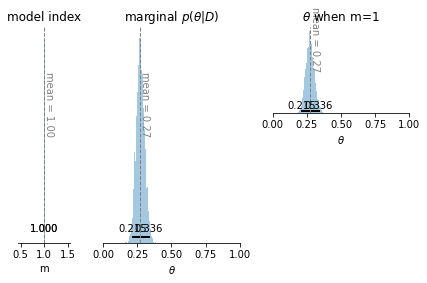

In [15]:
data = {'z': 7, 'N': 10, 'kappa': 202}
trace = run_model(code, data)
plot_hierarchy(trace)
models_probability(trace)

With $\kappa = 6$ the MCMC results are the same as the analytical results. With $\kappa = 202$, however, all of the chains got stuck with one model and failed to jump to the other, more probable model. Psuedo priors should solve that, but how can we set them up in the first place?

Note that initial parameter values are not randomised at the moment by JAGS (see page 16 in the [JAGS manual](https://people.stat.sc.edu/hansont/stat740/jags_user_manual.pdf), especially the last two paragraphs and the footnote). $m$ is initialized to 1 and is stuck there. See section 8.2.3 in the book for info about random initial values (a feature that pyjags doesn't support). Let's try initializing each chain with different $m$ value.

adapting: iterations 4000 of 4000, elapsed 0:00:00, remaining 0:00:00
sampling: iterations 10000 of 10000, elapsed 0:00:00, remaining 0:00:00


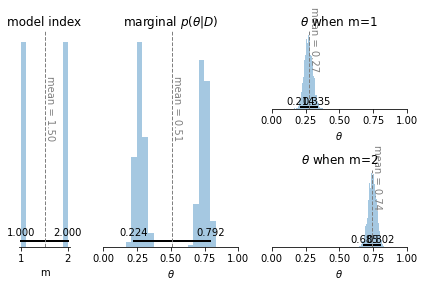

In [16]:
data = {'z': 7, 'N': 10, 'kappa': 202}
init = [{'m': i % 2 + 1} for i in range(CHAINS)]
trace = run_model(code, data, init=init)

plot_hierarchy(trace)

Obviously, the chains still don't jump between $m$ values.

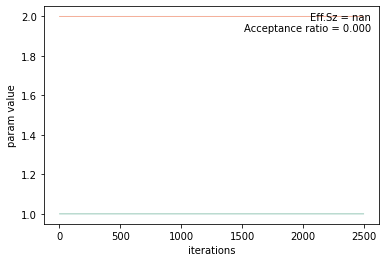

In [17]:
plot_utils.trace(trace['m'][0])

To answer my own question above about setting the psuedo priors: make sure to randomly initialize the parameters for each chain to find reasonable psuedo priors. Alternatively, check out exercise 3, question B.

# Exercise 3

Working with psuedo priors.

In [18]:
def plot_thetas(trace):
    _, axes = plt.subplots(nrows=2, ncols=2)
    for m, row_axes in zip([1, 2], axes):
        for theta, ax in zip([1, 2], row_axes):
            plot_utils.dist(trace[f'theta{theta}'][trace['m'] == m], ax=ax)
            ax.set(xlim=(0, 1), xlabel=fr'$\theta_{theta}$ | $m = {m}$')
    plt.tight_layout()

In [19]:
code = """
model {
    z ~ dbin(theta, N)
    
    theta = equals(m, 1) * theta1 + equals(m, 2) * theta2

    theta1 ~ dbeta(omega1[m] * (kappa1[m] - 2) + 1, (1 - omega1[m]) * (kappa1[m] - 2) + 1)
    omega1[1] = 0.1
    omega1[2] = omega1_psuedo_prior
    kappa1[1] = 20
    kappa1[2] = kappa1_psuedo_prior

    theta2 ~ dbeta(omega2[m] * (kappa2[m] - 2) + 1, (1 - omega2[m]) * (kappa2[m] - 2) + 1)
    omega2[1] = omega2_psuedo_prior
    omega2[2] = 0.9
    kappa2[1] = kappa2_psuedo_prior
    kappa2[2] = 20
    
    m ~ dcat(mPriorProb[])
    mPriorProb[1] = 0.5
    mPriorProb[2] = 0.5
}
"""

## Question A

MCMC run without psuedo priors.

In [20]:
data = {
    'z': 17,
    'N': 30,
    # No psuedo prior. These values are the true prior
    'omega1_psuedo_prior': 0.1,
    'kappa1_psuedo_prior': 20,
    'omega2_psuedo_prior': 0.9,
    'kappa2_psuedo_prior': 20,
}
model = pyjags.Model(code, data, chains=CHAINS)
trace = model.sample(vars=['theta1', 'theta2', 'm'], iterations=ITERATIONS)

adapting: iterations 4000 of 4000, elapsed 0:00:00, remaining 0:00:00
sampling: iterations 10000 of 10000, elapsed 0:00:00, remaining 0:00:00


/home/nagasaki45/code/dbdapy/mcmc_utils.py:64: RuntimeWarning: invalid value encountered in double_scalars
  return np.sqrt(marginal_posterior_var / w)


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7ff65f5b44f0>,
      dtype=object)

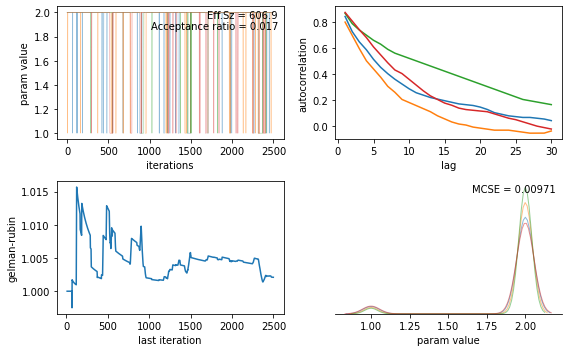

In [21]:
plot_utils.trace_analysis(trace['m'][0])

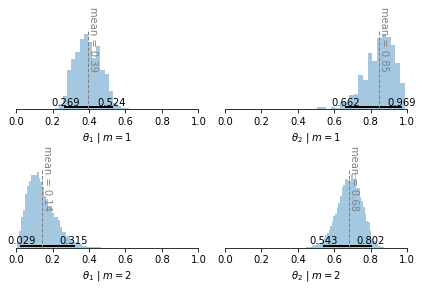

In [22]:
plot_thetas(trace)

Now with psuedo priors. The trace for $m$ should be much better.

In [23]:
data = {
    'z': 17,
    'N': 30,
    # Psuedo priors estimated from previous run
    'omega1_psuedo_prior': 0.4,
    'kappa1_psuedo_prior': 50,
    'omega2_psuedo_prior': 0.7,
    'kappa2_psuedo_prior': 50,
}
model = pyjags.Model(code, data, chains=CHAINS)
trace = model.sample(vars=['theta1', 'theta2', 'm'], iterations=ITERATIONS)

adapting: iterations 4000 of 4000, elapsed 0:00:00, remaining 0:00:00
sampling: iterations 10000 of 10000, elapsed 0:00:00, remaining 0:00:00


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7ff683f87730>,
      dtype=object)

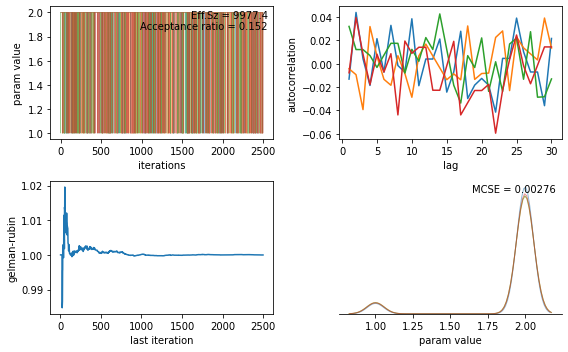

In [24]:
plot_utils.trace_analysis(trace['m'][0])

In [25]:
chains = trace['m'][0]
n, m = chains.shape
row_mean = np.mean(chains, axis=1)[:, np.newaxis]
grand_mean = np.mean(row_mean)
b = n / (m - 1) * np.sum(np.square(row_mean - grand_mean))
w = 1 / (m * (n - 1)) * np.sum(np.square(chains - row_mean))
marginal_posterior_var = (n - 1) / n * w + 1 / n * b
marginal_posterior_var
stat = np.sqrt(marginal_posterior_var / w)
stat

16.47254381902267

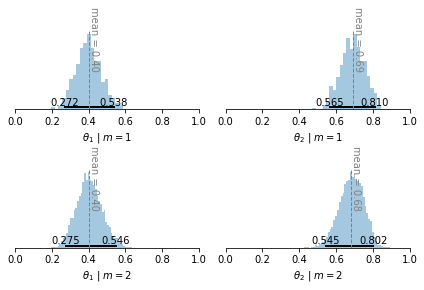

In [26]:
plot_thetas(trace)

## Question B

In [27]:
data = {
    'z': 17,
    'N': 30,
    # Vague psuedo priors
    'omega1_psuedo_prior': 0.5,
    'kappa1_psuedo_prior': 2.1,
    'omega2_psuedo_prior': 0.5,
    'kappa2_psuedo_prior': 2.1,
}
model = pyjags.Model(code, data, chains=CHAINS)
trace = model.sample(vars=['theta1', 'theta2', 'm'], iterations=ITERATIONS)

adapting: iterations 4000 of 4000, elapsed 0:00:00, remaining 0:00:00
sampling: iterations 10000 of 10000, elapsed 0:00:00, remaining 0:00:00


/home/nagasaki45/code/dbdapy/mcmc_utils.py:64: RuntimeWarning: invalid value encountered in double_scalars
  return np.sqrt(marginal_posterior_var / w)


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7ff65f5cf340>,
      dtype=object)

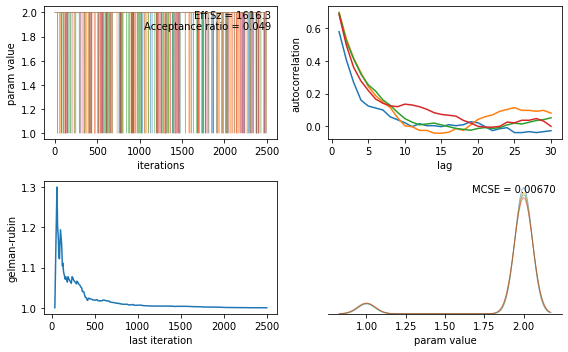

In [28]:
plot_utils.trace_analysis(trace['m'][0])

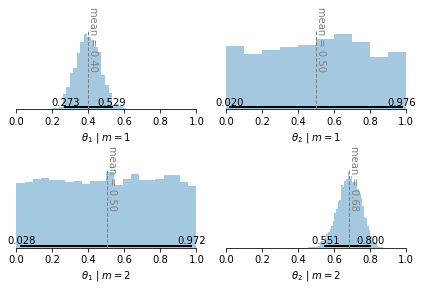

In [29]:
plot_thetas(trace)

Starting from a vague psuedo prior is probably better than starting from a more specific one as it allows the MCMC sampler to jump more easily as most values are still somewhat credible. It still doesn't replace setting up proper psuedo priors, but might be a reasonable first step.